# 1 - Logistic regression
In this part of the exercise, we will build a logistic regression model to predict wether a student gets admitted into an university

## 1.1 - Visualizing the data

In [21]:
%plot -f svg -w 1000
% load the data
addpath('includes/ex2')
data = load('ex2data1.txt');
X = data(:, [1, 2]); y = data(:, 3);

In [22]:
function plotData(X, y)
    figure;
    hold on;
    % find indices of positive and negative examples
    positive = find(y==1);
    negative = find(y==0);

    % Plot
    plot(X(positive, 1), X(positive, 2), 'k+', 'MarkerSize', 5, 'LineWidth', 2);
    plot(X(negative, 1), X(negative, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 5);

    hold off;
endfunction

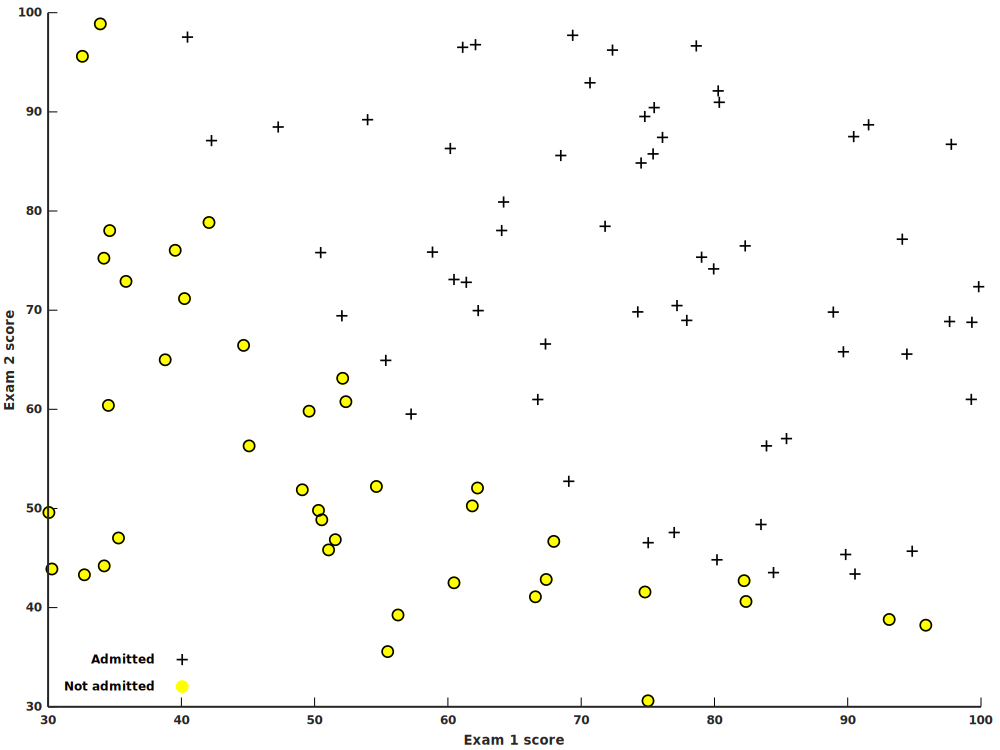

In [23]:
plotData(X, y);

% Put some labels 
hold on;
% Labels and Legend
xlabel('Exam 1 score')
ylabel('Exam 2 score')

% Specified in plot order
legend('Admitted', 'Not admitted');
legend left;
legend boxoff;
legend location southwest;
hold off;

## 1.2 - Implementation

### 1.2.1 - Warmup exercise: sigmoid function

The sigmoid function is defined as follows:

$$
g(z) = \frac{1}{1+e^{-z}}
$$

In [24]:
function g = sigmoid(z)
    g = zeros(size(z));
    g = 1./(1+exp(-z));
endfunction

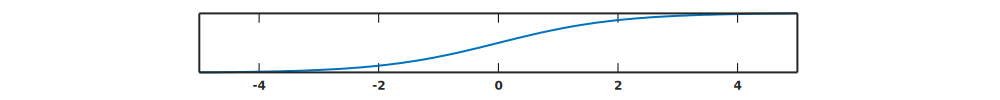

In [25]:
%plot -f svg -h 100 -w 1000
% We plot our function to check if it is correct
A = -5:0.05:5;
figure;
plot(A, sigmoid(A), '-');
axis image ticx;

### 1.2.2 - Cost function and gradient

In [26]:
[m, n] = size(X);

% Add intercept term to x and X_test
X = [ones(m, 1) X];

% Initialize fitting parameters
initial_theta = zeros(n + 1, 1);

In [27]:
function [J, grad] = costFunction(theta, X, y)
    m = length(y);

    hypothesis = sigmoid(X*theta);
    J = 1/m * sum(-y.*log(hypothesis) - (1-y).*log(1-hypothesis));

    grad = 1/m * X'*(hypothesis-y);
endfunction

In [28]:
[cost, grad] = costFunction(initial_theta, X, y);

fprintf('Cost at initial theta (zeros): %f\n', cost);
fprintf('Expected cost (approx): 0.693\n');
fprintf('Gradient at initial theta (zeros): \n');
fprintf(' %f \n', grad);
fprintf('Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628\n');

test_theta = [-24; 0.2; 0.2];
[cost, grad] = costFunction(test_theta, X, y);

fprintf('\nCost at test theta: %f\n', cost);
fprintf('Expected cost (approx): 0.218\n');
fprintf('Gradient at test theta: \n');
fprintf(' %f \n', grad);
fprintf('Expected gradients (approx):\n 0.043\n 2.566\n 2.647\n');

Cost at initial theta (zeros): 0.693147
Expected cost (approx): 0.693
Gradient at initial theta (zeros): 
 -0.100000 
 -12.009217 
 -11.262842 
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628

Cost at test theta: 0.218330
Expected cost (approx): 0.218
Gradient at test theta: 
 0.042903 
 2.566234 
 2.646797 
Expected gradients (approx):
 0.043
 2.566
 2.647


### 1.2.3 - Learning parameters with `fminunc`

In [29]:
%  Set options for fminunc
options = optimset('GradObj', 'on', 'MaxIter', 400);

%  Run fminunc to obtain the optimal theta
%  This function will return theta and the cost 
[theta, cost] = ...
   fminunc(@(t)(costFunction(t, X, y)), initial_theta, options);

In [30]:
fprintf('Cost at theta found by fminunc: %f\n', cost);
fprintf('Expected cost (approx): 0.203\n');
fprintf('theta: \n');
fprintf(' %f \n', theta);
fprintf('Expected theta (approx):\n');
fprintf(' -25.161\n 0.206\n 0.201\n');

Cost at theta found by fminunc: 0.203498
Expected cost (approx): 0.203
theta: 
 -25.161272 
 0.206233 
 0.201470 
Expected theta (approx):
 -25.161
 0.206
 0.201


We plot the decision boundary

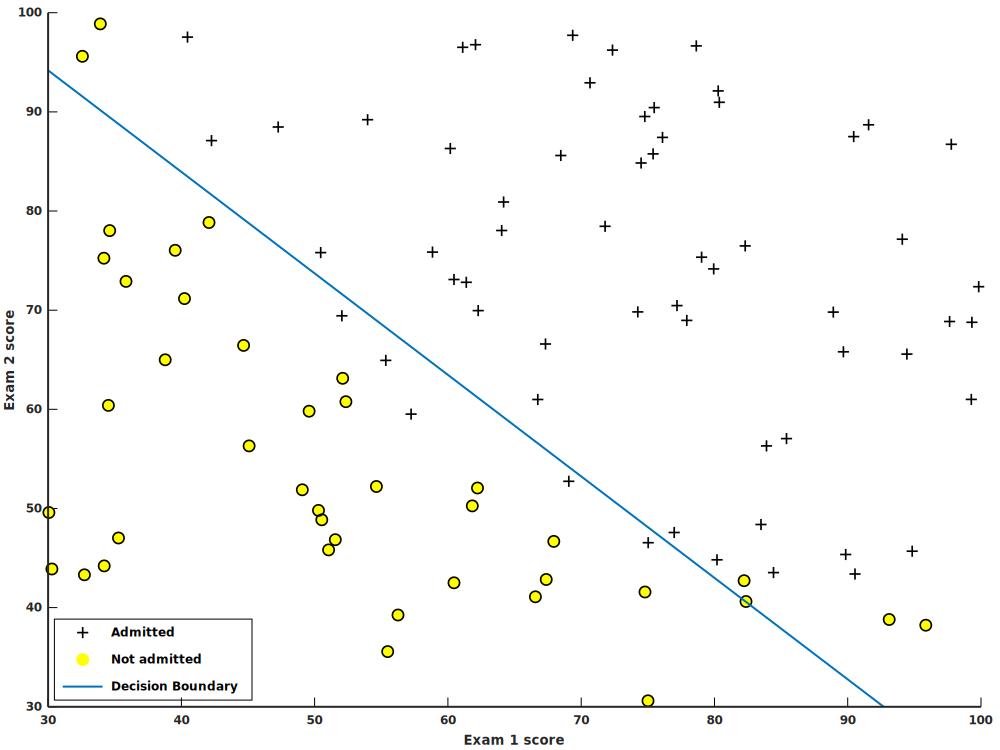

In [31]:
%plot -f svg -h -1 -w 1000
% Plot Data
plotData(X(:,2:3), y);
hold on;

plot_x = [min(X(:,2))-2,  max(X(:,2))+2];

% Calculate the decision boundary line
plot_y = (-1./theta(3)).*(theta(2).*plot_x + theta(1));

% Plot, and adjust axes for better viewing
plot(plot_x, plot_y, 'LineWidth', 2)
    
% Legend, specific for the exercise
legend('Admitted', 'Not admitted', 'Decision Boundary');
axis([30 100 30 100])
xlabel('Exam 1 score')
ylabel('Exam 2 score')
legend location southwest;
hold off;

### 1.2.4 - Evaluating logistic regression

In [32]:
function p = predict (theta, X)
    p = round(sigmoid(X*theta));
endfunction

In [33]:
prob = sigmoid([1 45 85] * theta);
fprintf(['For a student with scores 45 and 85, we predict an admission ' ...
         'probability of %f\n'], prob);
fprintf('Expected value: 0.775 +/- 0.002\n\n');

% Compute accuracy on our training set
p = predict(theta, X);

fprintf('Train Accuracy: %f\n', mean(double(p == y)) * 100);
fprintf('Expected accuracy (approx): 89.0\n');
fprintf('\n');

For a student with scores 45 and 85, we predict an admission probability of 0.776289
Expected value: 0.775 +/- 0.002

Train Accuracy: 89.000000
Expected accuracy (approx): 89.0



# 2 - Regularized logistic regression

We will implement regularized logistic regression to predict wether microchips from a fabrication plan passes the quality assurance.


## 2.1 - Visualizing the data

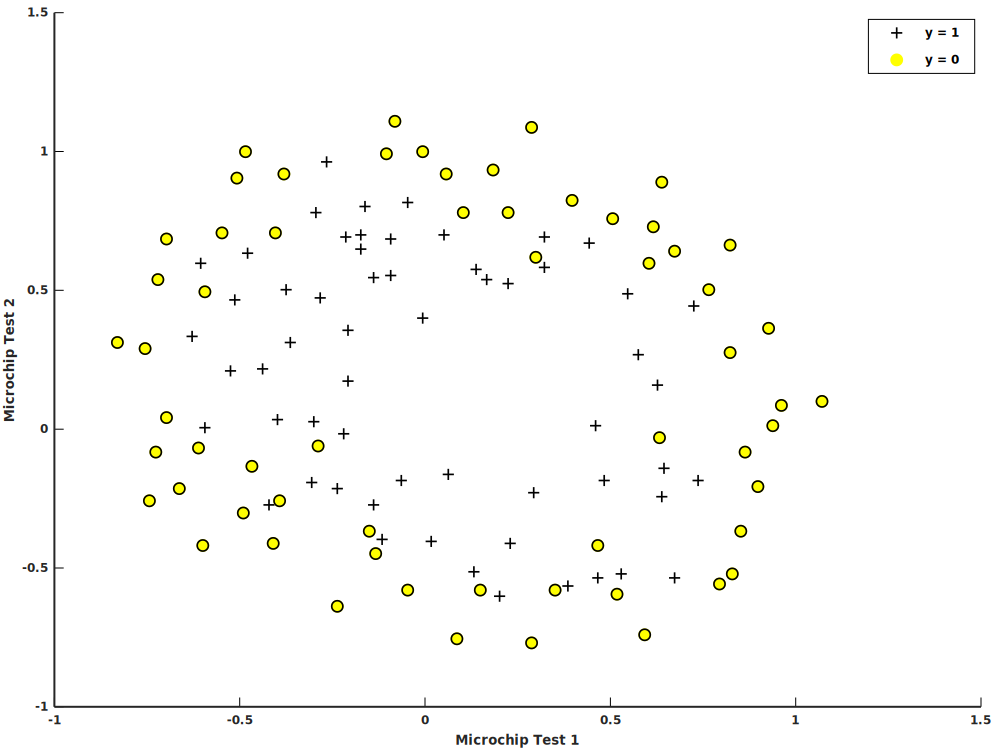

In [34]:
clear
data = load('ex2data2.txt');
X = data(:, [1, 2]); y = data(:, 3);

plotData(X, y);

% Put some labels
hold on;

% Labels and Legend
xlabel('Microchip Test 1')
ylabel('Microchip Test 2')

% Specified in plot order
legend('y = 1 ', 'y = 0 ')
hold off;

## 2.2 - Feature mapping

In [35]:
function out = mapFeature(X1, X2)
    degree = 6;
    out = ones(size(X1(:,1)));
    for i = 1:degree
        for j = 0:i
            out(:, end+1) = (X1.^(i-j)).*(X2.^j);
        end
    end

endfunction

The function above transforms a two-feature vector into a 28-feature one.

### 2.3 - Cost function and gradient

In [36]:
function [J, grad] = costFunctionReg(theta, X, y, lambda)
    m = length(y);

    hypothesis = sigmoid(X*theta);
    J = 1/m * sum(-y.*log(hypothesis) - (1-y).*log(1-hypothesis)) + lambda/(2*m) * sum(theta(2:length(theta)).^2);

    % We do not regularize theta0
    grad = 1/m * X'*(hypothesis-y);
    grad(2:end) = grad(2:end) + lambda * theta(2:end) ./ m;
endfunction

In [37]:
X = mapFeature(X(:,1), X(:,2));

% Initialize fitting parameters
initial_theta = zeros(size(X, 2), 1);

% Set regularization parameter lambda to 1
lambda = 1;

% Compute and display initial cost and gradient for regularized logistic
% regression
[cost, grad] = costFunctionReg(initial_theta, X, y, lambda);

fprintf('Cost at initial theta (zeros): %f\n', cost);
fprintf('Expected cost (approx): 0.693\n');
fprintf('Gradient at initial theta (zeros) - first five values only:\n');
fprintf(' %f \n', grad(1:5));
fprintf('Expected gradients (approx) - first five values only:\n');
fprintf(' 0.0085\n 0.0188\n 0.0001\n 0.0503\n 0.0115\n');

Cost at initial theta (zeros): 0.693147
Expected cost (approx): 0.693
Gradient at initial theta (zeros) - first five values only:
 0.008475 
 0.018788 
 0.000078 
 0.050345 
 0.011501 
Expected gradients (approx) - first five values only:
 0.0085
 0.0188
 0.0001
 0.0503
 0.0115


In [38]:
% Initialize fitting parameters
initial_theta = zeros(size(X, 2), 1);

% Set regularization parameter lambda to 1
lambda = 1;

% Set Options
options = optimset('GradObj', 'on', 'MaxIter', 400);

% Optimize
[theta, J, exit_flag] = ...
    fminunc(@(t)(costFunctionReg(t, X, y, lambda)), initial_theta, options);

## 2.4 - Plotting the decision boundary
We use the provided `plotDecisionBoundary` function

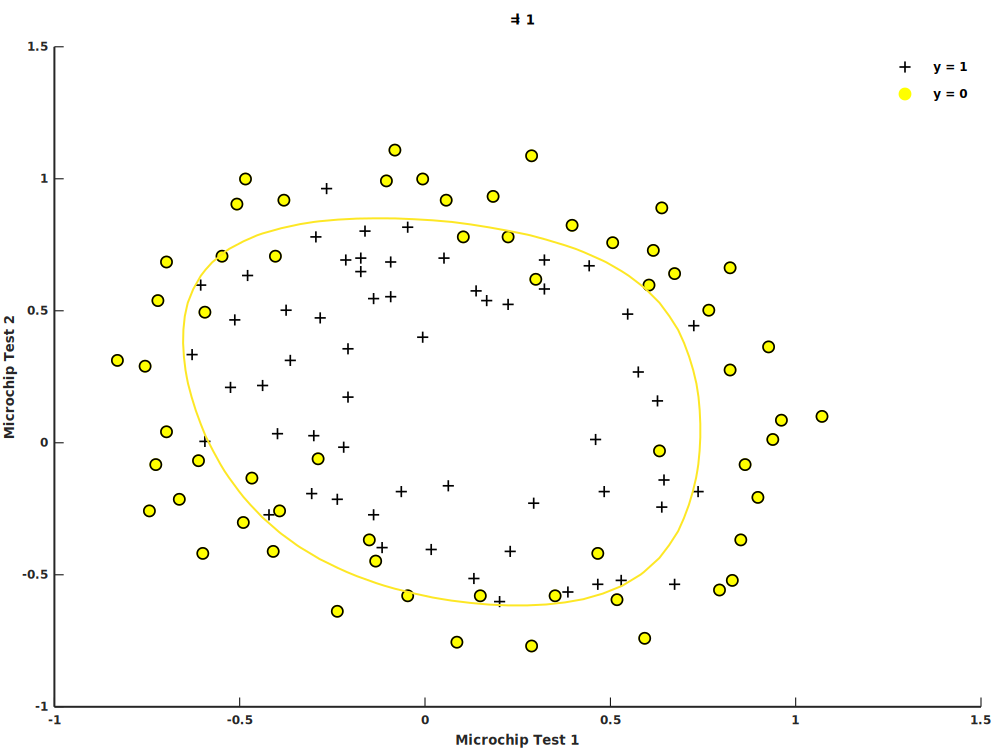

In [41]:
plotDecisionBoundary(theta, X, y);
hold on;
title(sprintf('\\lambda = %g', lambda))

% Labels and Legend
xlabel('Microchip Test 1')
ylabel('Microchip Test 2')

legend('y = 1', 'y = 0', 'Decision boundary')
legend boxoff;
hold off;

In [40]:
% Calculate accuracy
p = predict(theta, X);

fprintf('Train Accuracy: %f\n', mean(double(p == y)) * 100);
fprintf('Expected accuracy (with lambda = 1): 83.1 (approx)\n');


Train Accuracy: 83.050847
Expected accuracy (with lambda = 1): 83.1 (approx)
